In [1]:
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk
import sys
import os

### Reading CT, PET corr and PET uncorr to resample everything to PET_corr size

In [2]:
readerCT = sitk.ImageSeriesReader()

data_directory = '/mnt/Data_ubuntu/datasets/CT_PET_Corr_Uncorr/20170215 084826 [ - PET 21 PETCT Hals KM  Adult]/Series 003 [CT - Hals KM 3 SAFIRE]/'
seriesIDs = readerCT.GetGDCMSeriesIDs(data_directory) 
print('Found Series ID: ', seriesIDs)

dicom_names = readerCT.GetGDCMSeriesFileNames(data_directory, seriesIDs[0])
# print(dicom_names)
readerCT.SetFileNames(dicom_names)
imageCT = readerCT.Execute()
sizeCT = imageCT.GetSize()
print(sizeCT)

Found Series ID:  ('1.3.6.1.4.1.5962.99.1.4085442014.129914398.1610403243486.13650.0',)
(512, 512, 139)


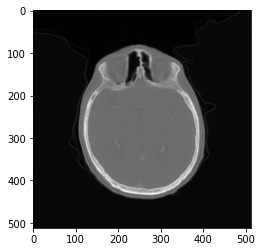

In [3]:
plt.imshow(sitk.GetArrayViewFromImage(imageCT)[100,:,:], cmap='gray')

In [4]:
readerPETc = sitk.ImageSeriesReader()

data_directory = '/mnt/Data_ubuntu/datasets/CT_PET_Corr_Uncorr/20170215 084826 [ - PET 21 PETCT Hals KM  Adult]/Series 005 [PT - PET corr]/'
seriesIDs = readerCT.GetGDCMSeriesIDs(data_directory) 
print('Found Series ID: ', seriesIDs)

dicom_names = readerCT.GetGDCMSeriesFileNames(data_directory, seriesIDs[0])
# print(dicom_names)
readerPETc.SetFileNames(dicom_names)
imagePETc = readerPETc.Execute()
sizePETc = imagePETc.GetSize()
print(sizePETc)

Found Series ID:  ('1.3.6.1.4.1.5962.99.1.4085442014.129914398.1610403243486.13792.0',)
(400, 400, 116)


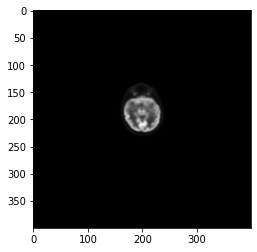

In [5]:
plt.imshow(sitk.GetArrayViewFromImage(imagePETc)[83,:,:], cmap='gray')

In [6]:
dimension = imagePETc.GetDimension()
print(dimension)

# Physical image size corresponds to the largest physical size in the training set, or any other arbitrary size.
reference_physical_size = np.zeros(dimension)
print(reference_physical_size)
for img in [imagePETc,imageCT]:
    reference_physical_size[:] = [(sz-1)*spc if sz*spc>mx  else mx for sz,spc,mx in zip(img.GetSize(), img.GetSpacing(), reference_physical_size)]
    print(reference_physical_size)
    
# Create the reference image with a zero origin, identity direction cosine matrix and dimension     
reference_origin = np.zeros(dimension)
reference_direction = np.identity(dimension).flatten()
reference_size = [400,400,128] # Arbitrary sizes, smallest size that yields desired results. 
reference_spacing = [ phys_sz/(sz-1) for sz,phys_sz in zip(reference_size, reference_physical_size) ]

reference_image = sitk.Image(reference_size, imageCT.GetPixelIDValue())
reference_image.SetOrigin(reference_origin)
reference_image.SetSpacing(reference_spacing)
reference_image.SetDirection(reference_direction)

# Always use the TransformContinuousIndexToPhysicalPoint to compute an indexed point's physical coordinates as 
# this takes into account size, spacing and direction cosines. For the vast majority of images the direction 
# cosines are the identity matrix, but when this isn't the case simply multiplying the central index by the 
# spacing will not yield the correct coordinates resulting in a long debugging session. 
reference_center = np.array(reference_image.TransformContinuousIndexToPhysicalPoint(np.array(reference_image.GetSize())/2.0))

3
[0. 0. 0.]
[812.53158 812.53158 345.     ]
[812.53158 812.53158 345.     ]


In [10]:
list_img = []
for img in [imageCT, imagePETc]:
    # Transform which maps from the reference_image to the current img with the translation mapping the image
    # origins to each other.
    transform = sitk.AffineTransform(dimension)
    transform.SetMatrix(img.GetDirection())
    transform.SetTranslation(np.array(img.GetOrigin()) - reference_origin)
    # Modify the transformation to align the centers of the original and reference image instead of their origins.
    centering_transform = sitk.TranslationTransform(dimension)
    img_center = np.array(img.TransformContinuousIndexToPhysicalPoint(np.array(img.GetSize())/2.0))
    centering_transform.SetOffset(np.array(transform.GetInverse().TransformPoint(img_center) - reference_center))
    centered_transform = sitk.Transform(transform)
    centered_transform.AddTransform(centering_transform)
#     centered_transform = sitk.CompositeTransform([centered_transform, centering_transform])
    # Using the linear interpolator as these are intensity images, if there is a need to resample a ground truth 
    # segmentation then the segmentation image should be resampled using the NearestNeighbor interpolator so that 
    # no new labels are introduced.
    list_img.append(sitk.Resample(img, reference_image, centered_transform, sitk.sitkLinear, 0.0))

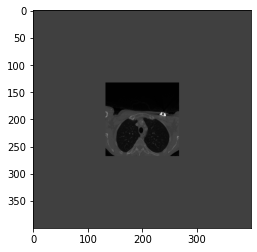

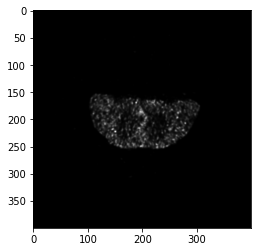

In [11]:
img1, img2 = sitk.GetArrayViewFromImage(list_img[0]), sitk.GetArrayViewFromImage(list_img[1])

idx = 0
plt.imshow(img1[idx,:,:], cmap='gray')
plt.show()
plt.imshow(img2[idx,:,:], cmap='gray')
plt.show()

In [12]:
imageCTnpy, imagePETcnpy = sitk.GetArrayViewFromImage(imageCT), sitk.GetArrayViewFromImage(imagePETc)
print(imageCTnpy.shape, imagePETcnpy.shape)

(139, 512, 512) (116, 400, 400)


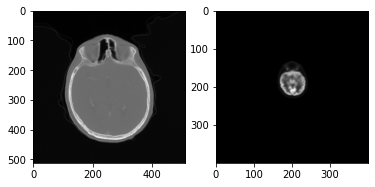

In [13]:
plt.figure()
plt.subplot(1,2,1)
plt.imshow(imageCTnpy[100,:,:], cmap='gray')
plt.subplot(1,2,2)
plt.imshow(imagePETcnpy[83,:,:], cmap='gray')
plt.show()

In [14]:
import torchio as tio

In [15]:
CT_image = tio.ScalarImage('/mnt/Data_ubuntu/datasets/CT_PET_Corr_Uncorr/20170215 084826 [ - PET 21 PETCT Hals KM  Adult]/Series 003 [CT - Hals KM 3 SAFIRE]/')
CT_image.shape

(1, 512, 512, 139)

In [16]:
PETc_image = tio.ScalarImage('/mnt/Data_ubuntu/datasets/CT_PET_Corr_Uncorr/20170215 084826 [ - PET 21 PETCT Hals KM  Adult]/Series 005 [PT - PET corr]/')
PETc_image.shape

(1, 400, 400, 116)

In [17]:
transform = tio.Resample(PETc_image)   

In [18]:
tfm_CT_img = transform(CT_image)

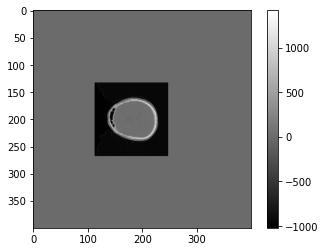

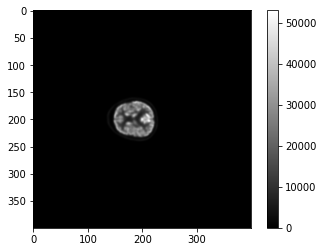

In [19]:
idx = 90

plt.imshow(tfm_CT_img.data[0,:,:,90], cmap='gray')
plt.colorbar()
plt.show()
plt.imshow(PETc_image.data[0,:,:,90], cmap='gray')
plt.colorbar()
plt.show()

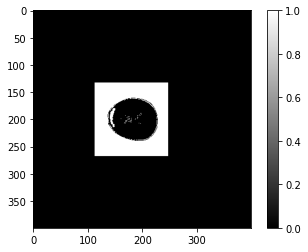

In [20]:
plt.imshow(tfm_CT_img.data[0,:,:,90]<0, cmap='gray')
plt.colorbar()
plt.show()

In [60]:
def get_crop_CT(CT_img, PET_img, thr, idx):
    mask = CT_img<thr
    _, X, Y, _ = np.where(mask==True)
    x1, y1 = X[0], Y[0]
    x2, y2 = X[-1], Y[-1]
    plt.imshow(CT_img[0,x1:x2, y1:y2,idx]/1000, cmap='gray')
    plt.colorbar()
    plt.show()
    plt.imshow(PET_img[0,x1:x2, y1:y2,idx], cmap='gray')
    plt.colorbar()
    plt.show()
    a = PET_img[0,x1:x2, y1:y2,idx]
    plt.imshow(np.log(np.clip(a, a_min=1, a_max=np.max(a.numpy()))), cmap='gray')
    plt.colorbar()
    plt.show()

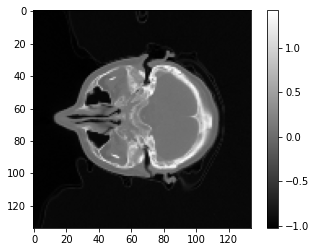

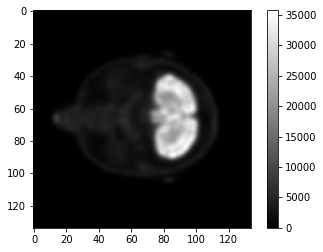

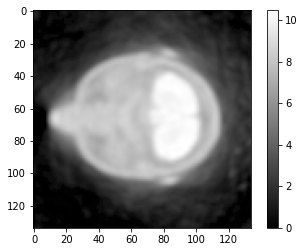

In [61]:
get_crop_CT(tfm_CT_img.data, PETc_image.data, 0, 70)